Copyright (c) 2017, Johannes Schöneberg. All rights reserved.
The default copyright laws apply.

In [24]:
%matplotlib inline

#http://www.lighthacking.nl/nd2reader/tutorial.html
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd


import skimage
import json

#own modules / functions
import sys
pythonPackagePath = "/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis/"
sys.path.append(pythonPackagePath+"/modules")
import InputProcessing as inproc
import ForceFileProcessing as ffp

In [26]:
path = '/Users/johannesschoeneberg/Dropbox/ESCRT_data_sharing/m7_2018-06-13_v2/'

inputParameters = pd.read_csv(path+'_info.csv',names=['key','value'])

inputDataFolder = inproc.getInputParameter(inputParameters,"input_data_folder")


inputParameters[0:5]

,key,value
0,key,value
1,key,value
2,input_data_folder,./
3,output_data_folder,./
4,vesicleID_of_that_day,2


In [21]:

moviePath = '/Volumes/Samsung_T3b/science/confleezers/2018-07-14/v10b1.nd2'
outputPathForIndividualChannels = '/Volumes/Samsung_T3b/science/confleezers/2018-07-14/v10b1_processing'


#moviePath = '/Users/johannesschoeneberg/Desktop/PostDoc/hurley_lab/pulling_confleezers_dataSharing_local/2018-06-05_movie1/movie_raw.nd2'
#outputPathForIndividualChannels = '/Users/johannesschoeneberg/Desktop/PostDoc/hurley_lab/pulling_confleezers_dataSharing_local/2018-06-05_movie1/'

movie =  ND2Reader(moviePath)
print(movie)

#print(movie.metadata['width'])
#print(movie.metadata['height'])
print(movie.metadata['date'])
#print(movie.metadata['fields_of_view'])
#print(movie.metadata['frames'])
#print(movie.metadata['z_levels'])
#print(movie.metadata['total_images_per_channel'])
#print(movie.metadata['channels'])
print('px to microns %f px/µm' %(movie.metadata['pixel_microns']))
#print(movie.metadata['rois'])
print(movie.metadata['experiment'])


# write the movie date to the _info.csv
row = inputParameters.loc[inputParameters['key'] == 'movie_startTime']
inputParameters.loc[row.index,'value'] = movie.metadata['date']
print(inputParameters.loc[inputParameters['key'] == 'movie_startTime'])
inputParameters.to_csv(path+'_info.csv',index=False)

<FramesSequenceND>
Axes: 4
Axis 'x' size: 512
Axis 'y' size: 512
Axis 'c' size: 4
Axis 't' size: 1600
Pixel Datatype: <class 'numpy.float64'>
2018-07-14 17:23:04
px to microns 0.051790 px/µm
{'description': 'ND Acquisition', 'loops': [{'start': 0, 'duration': 3540000.0, 'stimulation': False, 'sampling_interval': 60000.0}, {'start': 3540000.0, 'duration': 60000.0, 'stimulation': False, 'sampling_interval': 60000.0}, {'start': 3600000.0, 'duration': 900000.0, 'stimulation': False, 'sampling_interval': 1.0}]}


# look at the first movie frame

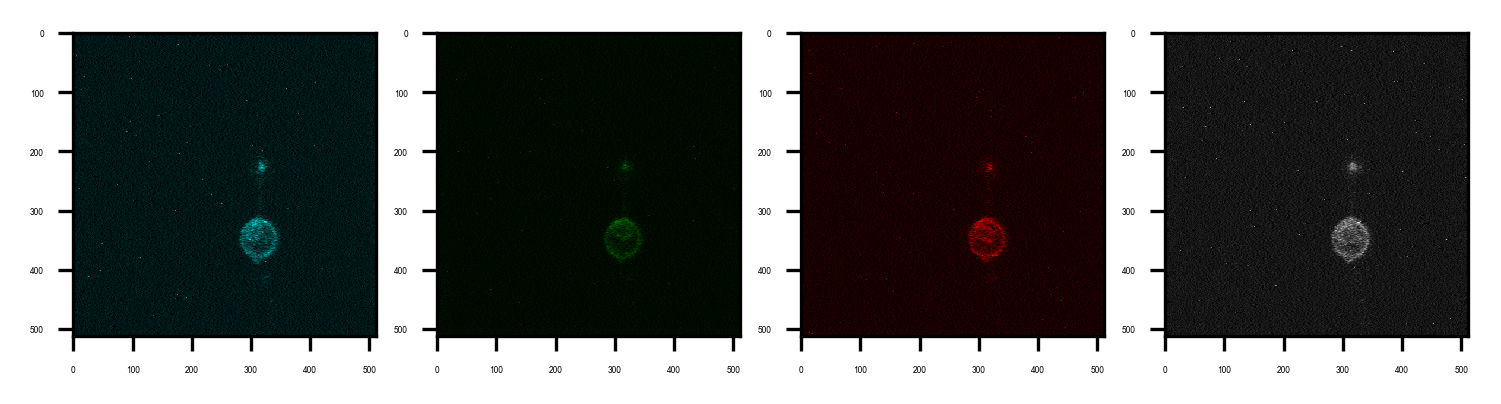

In [4]:




cmap_ch0 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","cyan"])
cmap_ch1= matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
cmap_ch2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
cmap_ch3= matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","white"])

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 2}

matplotlib.rc('font', **font)

plt.figure(dpi=300)

# sp1
plt.subplot(141)
plt.imshow(movie[0],cmap=cmap_ch0)

# sp1
plt.subplot(142)
plt.imshow(movie[1],cmap=cmap_ch1)

# sp1
plt.subplot(143)
plt.imshow(movie[2],cmap=cmap_ch2)

# sp1
plt.subplot(144)
plt.imshow(movie[3],cmap=cmap_ch3)


# Crop the movie according to Fiji (test there what looks good, then implement it here)



![title](figures/fig_movie0_crop.png)

In [5]:
crop_xStart = 220
crop_xWidth = 176
crop_yStart = 146
crop_yHeight = 298


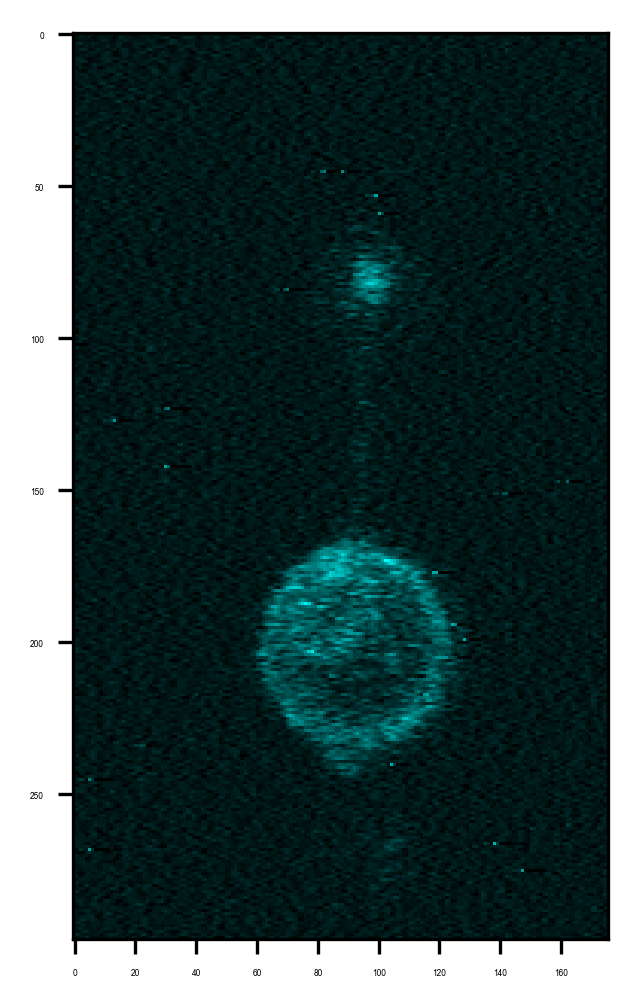

In [9]:
plt.figure(dpi=300)
plt.imshow(movie[0][yStart:yStart+yHeight,xStart:xStart+xWidth],cmap=cmap_ch0)

In [10]:
averaging = True
winsize = 20

for i in range(movie.sizes['c']):
    # do the  channels individually (otherwise it might blow out your RAM)

    channelID = i

    movie_ch = []
    movie.default_coords['c'] = channelID
    movie.iter_axes = 't'
    for t in range(0,movie.sizes['t']):
        movie_ch.append(movie[t][yStart:yStart+yHeight,xStart:xStart+xWidth])
    
    movie_ch = np.array(movie_ch)
    data = movie_ch.astype('uint16')
    metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
    print(data.shape, data.dtype, metadata['microscope'])
    metadata = json.dumps(metadata)
    print(metadata)

    outputPath = outputPathForIndividualChannels+'/movie_ch'+str(channelID)+'.tif'
    print(outputPath)
    skimage.external.tifffile.imsave(outputPath, data, description=metadata)
    
    if(averaging):
        mvgAvgInput = movie_ch
        movie_ch_moveAvg = []
        for i in range (0,len(mvgAvgInput)-winsize):
            movie_ch_moveAvg.append(np.average(mvgAvgInput[i:i+winsize],axis=0))
        
        movie_ch_moveAvg = np.array(movie_ch_moveAvg)
        data = movie_ch_moveAvg.astype('uint16')
        metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
        print(data.shape, data.dtype, metadata['microscope'])
        metadata = json.dumps(metadata)
        print(metadata)
    
        outputPath = outputPathForIndividualChannels+'/movie_ch'+str(channelID)+'_avg'+str(winsize)+'.tif'
        print(outputPath)
        skimage.external.tifffile.imsave(outputPath, data, description=metadata)    

(1600, 298, 176) uint16 joh
{"microscope": "joh", "shape": [1600, 298, 176], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-14/v10b1_processing/movie_ch0.tif
(1580, 298, 176) uint16 joh
{"microscope": "joh", "shape": [1580, 298, 176], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-14/v10b1_processing/movie_ch0_avg20.tif
(1600, 298, 176) uint16 joh
{"microscope": "joh", "shape": [1600, 298, 176], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-14/v10b1_processing/movie_ch1.tif
(1580, 298, 176) uint16 joh
{"microscope": "joh", "shape": [1580, 298, 176], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-14/v10b1_processing/movie_ch1_avg20.tif
(1600, 298, 176) uint16 joh
{"microscope": "joh", "shape": [1600, 298, 176], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-14/v10b1_processing/movie_ch2.tif
(1580, 298, 176) uint16 joh
{"microscope": "joh", "shape": [1580, 298, 176], "dtype": "<u2"}
/Volumes/Samsun

# No Cropping: split the movie into 4 individual tiff channels, and save the 20 win average as well


In [11]:
averaging = True
winsize = 20

for i in range(movie.sizes['c']):
    # do the  channels individually (otherwise it might blow out your RAM)

    channelID = i

    movie_ch = []
    movie.default_coords['c'] = channelID
    movie.iter_axes = 't'
    for t in range(0,movie.sizes['t']):
        movie_ch.append(movie[t][])
    
    movie_ch = np.array(movie_ch)
    data = movie_ch.astype('uint16')
    metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
    print(data.shape, data.dtype, metadata['microscope'])
    metadata = json.dumps(metadata)
    print(metadata)

    outputPath = outputPathForIndividualChannels+'/movie_ch'+str(channelID)+'.tif'
    print(outputPath)
    skimage.external.tifffile.imsave(outputPath, data, description=metadata)
    
    if(averaging):
        mvgAvgInput = movie_ch
        movie_ch_moveAvg = []
        for i in range (0,len(mvgAvgInput)-winsize):
            movie_ch_moveAvg.append(np.average(mvgAvgInput[i:i+winsize],axis=0))
        
        movie_ch_moveAvg = np.array(movie_ch_moveAvg)
        data = movie_ch_moveAvg.astype('uint16')
        metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
        print(data.shape, data.dtype, metadata['microscope'])
        metadata = json.dumps(metadata)
        print(metadata)
    
        outputPath = outputPathForIndividualChannels+'/movie_ch'+str(channelID)+'_avg'+str(winsize)+'.tif'
        print(outputPath)
        skimage.external.tifffile.imsave(outputPath, data, description=metadata)    

(2474, 512, 512) uint16 joh
{"microscope": "joh", "shape": [2474, 512, 512], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v24b1001_processed/movie_ch0.tif
(2454, 512, 512) uint16 joh
{"microscope": "joh", "shape": [2454, 512, 512], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v24b1001_processed/movie_ch0_avg20.tif
(2474, 512, 512) uint16 joh
{"microscope": "joh", "shape": [2474, 512, 512], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v24b1001_processed/movie_ch1.tif
(2454, 512, 512) uint16 joh
{"microscope": "joh", "shape": [2454, 512, 512], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v24b1001_processed/movie_ch1_avg20.tif
(2474, 512, 512) uint16 joh
{"microscope": "joh", "shape": [2474, 512, 512], "dtype": "<u2"}
/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v24b1001_processed/movie_ch2.tif
(2454, 512, 512) uint16 joh
{"microscope": "joh", "shape": [2454, 512, 512], "dtype": "<u2"}
/Volu

In [6]:
individualChannels = []
for ch in range(0,movie.sizes['c']):
    movie_ch = []
    movie.default_coords['c'] = ch
    movie.iter_axes = 't'
    for t in range(0,movie.sizes['t']):
        movie_ch.append(movie[t])
    individualChannels.append(np.array(movie_ch))
    

4

# other stuff that can be deleted if not useful

In [47]:
print(movie.sizes)
movie.iter_axes = 't'
images.default_coords['c'] = 1

{'x': 512, 'y': 512, 'c': 4, 't': 2702}


2702

In [ ]:
data = image.astype('uint16')
metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
print(data.shape, data.dtype, metadata['microscope'])
metadata = json.dumps(metadata)
print(metadata)

skimage.external.tifffile.imsave('./box_around_fiji_derived_coords.tif', data, description=metadata)

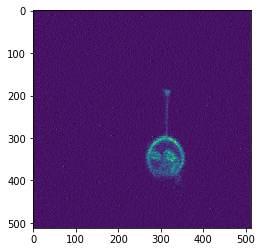

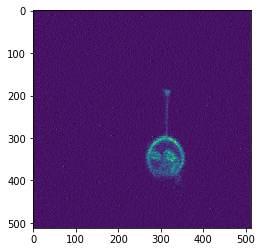

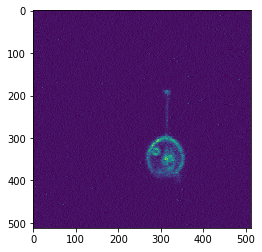

In [48]:
plt.imshow(movie[2])
plt.show()
plt.imshow(movie[3])


In [3]:
import csv


#http://soft-matter.github.io/trackpy/v0.3.2/tutorial/walkthrough.html


from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting


# Optionally, tweak styles.
#mpl.rc('figure',  figsize=(10, 6))
#mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
#import trackpy as tp

import scipy


import math

from scipy import optimize

import scipy.ndimage

Text(0,0.5,'length [px]')

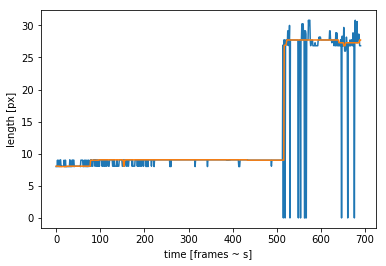

In [8]:
# read the movie frames

frames_ch1 = pims.TiffStack_pil('./input/vesicle_tube_UV_movie__ch1_walkavg10.tif')
frames_ch2 = pims.TiffStack_pil('./input/vesicle_tube_UV_movie__ch2_walkavg10.tif')
frames_ch3 = pims.TiffStack_pil('./input/vesicle_tube_UV_movie__ch3_walkavg10.tif')


# read the tube vector data from a upstream analysis
tube_vectors_fromFile = []
with open("./output/tube_vector.csv", "r") as f:
    reader = csv.reader(f)
    for line in reader:
        tube_vectors_fromFile.append(line)

#print(analysisResult_fromFile)
tubeVectors = np.array(tube_vectors_fromFile).astype(float)
tubeLength = tubeVectors[:,0]

plt.plot(tubeLength)
plt.plot(scipy.ndimage.median_filter(tubeLength,size=50))
plt.xlabel("time [frames ~ s]")
plt.ylabel("length [px]")
#plt.axvline(x=258,c='k')



In [7]:
def plotTubeVector(frameId,frames,tubeVectors):
    
    tubeVector = tubeVectors[frameId]
    vesicleAttachmentVector = (float(tubeVector[1]),float(tubeVector[2]))
    beadAttachmentVector = (float(tubeVector[3]),float(tubeVector[4]))

    #beadAttachmentVector=(vesicleAttachmentVector[0]*0.3,vesicleAttachmentVector[1])
    plt.imshow(frames[frameId],cmap='gray')
    #plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
    plt.plot([beadAttachmentVector[1], vesicleAttachmentVector[1]],
            [beadAttachmentVector[0], vesicleAttachmentVector[0]], 'r-', lw=2)

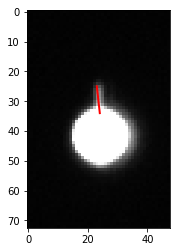

In [9]:
plotTubeVector(10,frames_ch3,tubeVectors)

In [10]:
#algorith:
#- get the vector of the tube
#- turn the frame by that vector (tube is now perfectly vertical)
#- collect all the horizontal lines of the tube, these are the tube intensities
#- analyze them

In [11]:
# L1 has points{(x1, y1), (x2, y2)} and L2 has points: {(x3, y3), (x4, y4)}
def angleBetweenLines(a,b,c,d):
    x1 = a[0]
    y1 = a[1]
    x2 = b[0]
    y2 = b[1]
    x3 = c[0]
    y3 = c[1]
    x4 = d[0]
    y4 = d[1]
    
    dx1 = x2-x1;
    dy1 = y2-y1;
    dx2 = x4-x3;
    dy2 = y4-y3;
    
    #print("dx1,dy1,dx2,dy2",dx1,dy1,dx2,dy2)
    
    d = dx1*dx2 + dy1*dy2;   # dot product of the 2 vectors
    #print("dot product",d)
    l2 = (dx1*dx1+dy1*dy1)*(dx2*dx2+dy2*dy2) # product of the squared lengths
    #print("squared lenghts",l2)
    # the arccos function gives a runtime warning if its input is >= 1.0
    # in that case I encounter tons of problems. 
    # the best solution is to not turn the frame at all in that case
    # found out by trying.
    arccosInput = np.round(np.absolute(d/np.sqrt(l2)),3)
    if(arccosInput>1.0):
        #print("arccos argument >1 : ",arccosInput)
        arccosInput = 1.0
        
    angle =np.arccos(arccosInput)
    
    return angle

In [12]:
def gaussian(B,x):
    ''' Returns the gaussian function for B=m,stdev,max,offset '''
    return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))

def errfunc(p,x,y):
    return y-gaussian(p,x)





def fitGaussian(data,verbose=False):

    # parameters of our gaussian

    
    
    
    y = data
    x = range(0,len(data))
    
    # initial estimate of parameters 
    p0 = [9,3,150,20]
    fit = optimize.leastsq(errfunc,p0,args=(x,y))
    
    if(verbose):
        print(fit)

    if(verbose):
        plt.plot(x,y,'k-',lw=3)
        plt.plot(x,gaussian(fit[0],x),'r-')
        plt.show()
    
    
    mean = fit[0][0]
    stdev = np.absolute(fit[0][1])
    offset = fit[0][3]
    FWHM = 2.355 * np.absolute(stdev)
    maxx = gaussian(fit[0],mean)
    fitconvergence = fit[1]

    if(verbose):
        print("mean:",mean,"stdev:", stdev,"max:", maxx,"FWHM:",FWHM,"offset:",offset)
    return(mean,stdev,maxx-offset,FWHM,maxx,offset,fitconvergence)

In [13]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points

def fitGaussianToTube(frameId,tubeVectors,frames):
    tubeVector = tubeVectors[frameId]
    vesicleAttachmentVector = (float(tubeVector[1]),float(tubeVector[2]))
    beadAttachmentVector = (float(tubeVector[3]),float(tubeVector[4]))
    tubeLength = int(float(tubeVector[0]))
    #vesicleAttachmentVector = beadAttachmentVector

    angle = angleBetweenLines(vesicleAttachmentVector,beadAttachmentVector,vesicleAttachmentVector,(vesicleAttachmentVector[0]*0.3,vesicleAttachmentVector[1]))


    angleDeg = 90*angle/math.pi

    #beadAttachmentVector=(vesicleAttachmentVector[0]*0.3,vesicleAttachmentVector[1])
    
    image = frames[frameId]
    margin = tubeLength*2
    #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
    midx = int(vesicleAttachmentVector[0])
    midy = int(vesicleAttachmentVector[1])
    image_centeredOnVesicleAttachmentVector = image[midx-margin:midx+margin,midy-margin:midy+margin]
    
    
    rotatedImage = scipy.ndimage.interpolation.rotate(image_centeredOnVesicleAttachmentVector, angleDeg, axes=(1, 0), reshape=True, output=None, order=3, mode='constant', cval=0.0, prefilter=True)

    
    midx = int(len(rotatedImage)/2)-1
    midy = int(len(rotatedImage[0])/2)-0
    marginX = int(tubeLength*1)
    marginY = 3*int(tubeLength/2)
    #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
    image_onlyTubeAfterRotation = rotatedImage[midx-marginX:midx,midy-marginY:midy+marginY]
    

    fitResults = fitGaussian(np.average(image_onlyTubeAfterRotation,axis=0))
    return fitResults
    
    

In [14]:
def channelIntensityAnalysis(tubeVectors,frames):
    fitResults = []
    for frameId in range(0,len(frames)):
        try:
            results = fitGaussianToTube(frameId,tubeVectors,frames)
            if(results[6]!=1):
                fitResults.append(np.zeros(7))
            else:
                fitResults.append(results)
        except (IndexError,TypeError,ZeroDivisionError):
                fitResults.append(np.zeros(7))
    return np.array(fitResults)

In [15]:
def filterResults(results,filterWindow):
    filteredResults = []
    for i in range(0,len(results[0])):
        filteredResults.append(scipy.ndimage.median_filter(results[:,i],size=filterWindow))
    return np.transpose(np.array(filteredResults))

In [16]:
# this function puts zeros in all positions after the scission event
def cleanTraceAfterScission(trace,breakFrameId):
    newTrace = []
    for i in range(0,len(trace)):
        if(i>=breakFrameId):
            newTrace.append(0)
        else:
            newTrace.append(trace[i])
    return newTrace

In [17]:
def filterAndCleanResults(results,filterWindow,breakFrameId):
    filteredResults = []
    for i in range(0,len(results[0])):
        filteredResults.append(scipy.ndimage.median_filter(cleanTraceAfterScission(results[:,i],breakFrameId),size=filterWindow))
    return np.transpose(np.array(filteredResults))

# Timing & parameters

In [18]:
time_UV = 150 #seconds after the force file was created
breakFrameId = 516
nFramesMovie = 700
pixelsPerMicron = 7.8363

filterWindowSize = 50

secondsPerFrame = 0.3744 #s/frame
forceFileLeadTime = 54 #seconds that the ff was started earlier than the movie

xlimit = (-180,220)

In [19]:
# calculate the time of the movie, normalized on the start of the force file



time = 1+np.arange(0,len(frames_ch1))

print(len(tubeLength))
print(len(time))
if(len(tubeLength)!=len(time)):
    print("ATTENTION: TUBE LENGTH TIME IS DIFFERENT FROM MOVIE TIME")

#print(secondsPerFrame*time)


timeShiftDueDoWalkAvg = nFramesMovie -len(frames_ch1)
#print(forceFileLeadTime+secondsPerFrame*time+timeShiftDueDoWalkAvg)
time = forceFileLeadTime+secondsPerFrame*time+timeShiftDueDoWalkAvg



691
691


# Calculate

In [20]:
results_ch1 = channelIntensityAnalysis(tubeVectors,frames_ch1)
filteredResults_ch1 = filterAndCleanResults(results_ch1,filterWindowSize,breakFrameId)

results_ch2 = channelIntensityAnalysis(tubeVectors,frames_ch2)
filteredResults_ch2 = filterAndCleanResults(results_ch2,filterWindowSize,breakFrameId)
nonZeroedFilteredResults_ch2 = filterResults(results_ch2,filterWindowSize)

results_ch3 = channelIntensityAnalysis(tubeVectors,frames_ch3)
filteredResults_ch3 = filterAndCleanResults(results_ch3,filterWindowSize,breakFrameId)

/Users/johannesschoeneberg/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Users/johannesschoeneberg/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/johannesschoeneberg/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/johannesschoeneberg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/Users/johannesschoeneberg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in absolute


In [21]:
## OUTPUT
def writeOutputToFile(filename,output_data,header):
    with open(filename,'wb') as f:
        np.savetxt(f, 
           output_data, 
           delimiter=',',
           fmt='%10.5f',
           header=header) 

In [22]:
# output Intensity File
output_data_intensity = np.transpose(np.asarray((time-time_UV,
                                          results_ch1[:,2],
                                          results_ch2[:,2],
                                          results_ch3[:,2])))

writeOutputToFile("./output/out_tube_fluorescenceIntensity_raw.csv",output_data_intensity,header="time[s], max intensity ch1[AU], max intensity ch2[AU], max intensity ch3[AU]")

# output Intensity File
output_data_intensity = np.transpose(np.asarray((time-time_UV,
                                          filteredResults_ch1[:,2],
                                          filteredResults_ch2[:,2],
                                          filteredResults_ch3[:,2])))

writeOutputToFile("./output/out_tube_fluorescenceIntensity.csv",output_data_intensity,header="time[s], max intensity ch1[AU], max intensity ch2[AU], max intensity ch3[AU]")


# output FWHM File
output_data_intensity = np.transpose(np.asarray((time-time_UV,
                                          1/pixelsPerMicron*filteredResults_ch1[:,3],
                                          1/pixelsPerMicron*filteredResults_ch2[:,3],
                                          1/pixelsPerMicron*filteredResults_ch3[:,3])))

writeOutputToFile("./output/out_tube_tubeRadius_FWHM.csv",output_data_intensity,header="time[s], FWHM ch1[µm],FWHM ch2[µm],FWHM ch3[µm]")




# Plot Tube Lenght again and Output

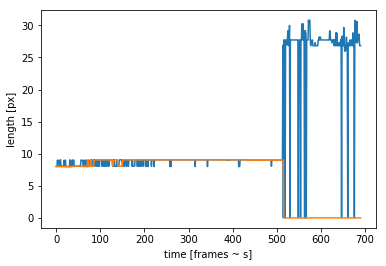

Text(0,0.5,'length [px]')

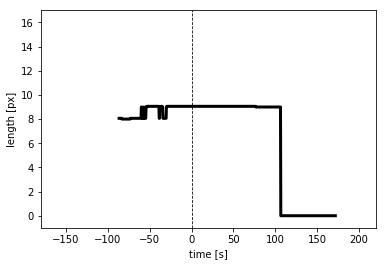

In [23]:


plt.plot(tubeLength)
plt.plot(scipy.ndimage.median_filter(cleanTraceAfterScission(tubeLength,breakFrameId),size=30))
plt.xlabel("time [frames ~ s]")
plt.ylabel("length [px]")
plt.show()

plt.plot(time-time_UV,scipy.ndimage.median_filter(cleanTraceAfterScission(tubeLength,breakFrameId),size=30),color='k',lw=3)
plt.xlabel("time [s]")
plt.axvline(0, color='k', linestyle='--', lw=0.8)
plt.ylim(-1,17)
plt.xlim(xlimit[0],xlimit[1])
plt.ylabel("length [px]")
#plt.axvline(x=258,c='k')

In [24]:
# output Intensity File
output_data_tubeLength = np.transpose(np.asarray((time-time_UV,1/pixelsPerMicron*scipy.ndimage.median_filter(cleanTraceAfterScission(tubeLength,breakFrameId),size=50))))

writeOutputToFile("./output/out_tube_length.csv",output_data_tubeLength,"time[s], tube length [µm]")


# Plots unfiltered raw intensities, FWHM et al.

In [26]:
#https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
c_ch1 = 'aqua'
c_ch1 = 'deepskyblue'
c_ch1 = 'cyan'

c_ch2 = 'springgreen'
c_ch2 = 'lime'
c_ch3 = 'red'
lwidth = 3

xlimit = (-150,300)

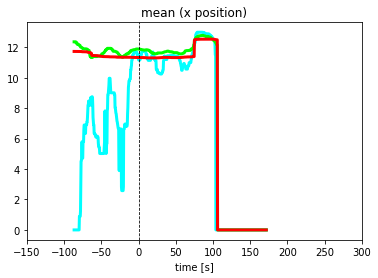

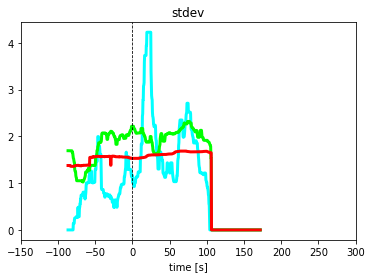

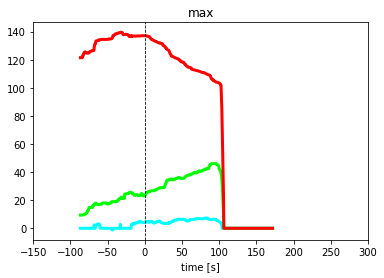

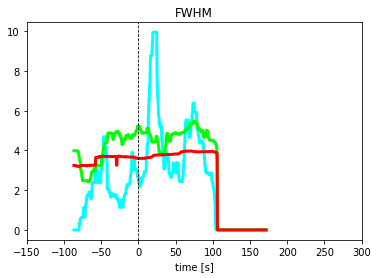

In [27]:
#plt.plot(results_ch3[:,0],c='r')
titles = ["mean (x position)","stdev","max","FWHM"]
for i in range(0,len(titles)):
    plt.plot(time-time_UV,filteredResults_ch1[:,i],c=c_ch1,lw=lwidth)
    plt.plot(time-time_UV,filteredResults_ch2[:,i],c=c_ch2,lw=lwidth)
    plt.plot(time-time_UV,filteredResults_ch3[:,i],c=c_ch3,lw=lwidth)
    plt.title(titles[i])
    plt.xlabel("time [s]")
    plt.axvline(0, color='k', linestyle='--', lw=0.8)
    plt.xlim(xlimit[0],xlimit[1])
    plt.show()
    



# Verbose version of fitGaussianToTube function

frameId:  470
vesicleAttachmentVector (34.0, 23.0)
beadAttachmentVector (25.0, 23.0)
angle between
tube length:  9
(vesicleAttachmentVector[0]*0.3,vesicleAttachmentVector[1] (44.2, 23.0)
angle: 0.0
angleDeg: 0.0


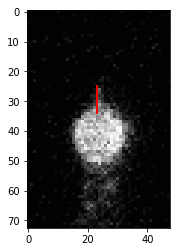

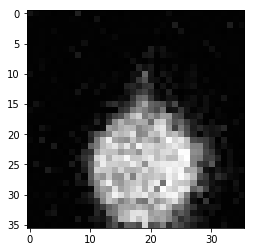

len  36  ,  36


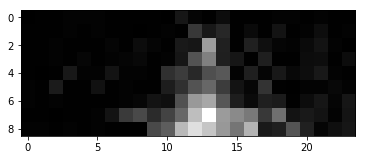

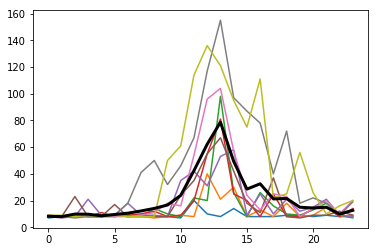

(array([  12.77811552,    1.55872814,  229.37541418,   12.73435772]), 1)


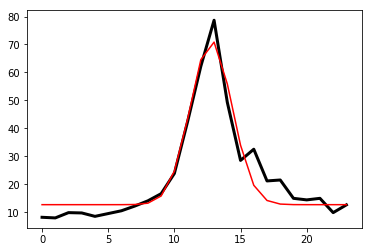

mean: 12.7781155169 stdev: 1.55872813735 max: 71.4409073844 FWHM: 3.67080476345 offset: 12.7343577246


(12.77811551685674,
 1.5587281373480488,
 58.706549659734762,
 3.670804763454655,
 71.44090738437032,
 12.734357724635556,
 1)

In [28]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch2

frameId = 470
print("frameId: ",frameId)
tubeVector = tubeVectors[frameId]
vesicleAttachmentVector = (float(tubeVector[1]),float(tubeVector[2]))
print("vesicleAttachmentVector",vesicleAttachmentVector)
beadAttachmentVector = (float(tubeVector[3]),float(tubeVector[4]))
print("beadAttachmentVector",beadAttachmentVector)


print("angle between")


tubeLength = int(float(tubeVector[0]))
#vesicleAttachmentVector = beadAttachmentVector
print("tube length: ",tubeLength)
angle = angleBetweenLines(vesicleAttachmentVector,beadAttachmentVector,(vesicleAttachmentVector[0]*1.3,vesicleAttachmentVector[1]),vesicleAttachmentVector)
print("(vesicleAttachmentVector[0]*0.3,vesicleAttachmentVector[1]",(vesicleAttachmentVector[0]*1.3,vesicleAttachmentVector[1]))
print("angle:",angle)
angleDeg = 90*angle/math.pi
print("angleDeg:",angleDeg)
# if the difference between calculated angle and real angle is > than go for the default angle

#beadAttachmentVector=(vesicleAttachmentVector[0]*0.3,vesicleAttachmentVector[1])

image = frames[frameId]
margin = tubeLength*2
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
midx = int(vesicleAttachmentVector[0])
midy = int(vesicleAttachmentVector[1])
image_centeredOnVesicleAttachmentVector = image[midx-margin:midx+margin,midy-margin:midy+margin]

plt.imshow(image,cmap='gray')
plt.plot([beadAttachmentVector[1], vesicleAttachmentVector[1]],
            [beadAttachmentVector[0], vesicleAttachmentVector[0]], 'r-', lw=2)
plt.show()

rotatedImage = scipy.ndimage.interpolation.rotate(image_centeredOnVesicleAttachmentVector, angleDeg, axes=(1, 0), reshape=True, output=None, order=3, mode='constant', cval=0.0, prefilter=True)
plt.imshow(rotatedImage,cmap='gray')
plt.show()

midx = int(len(rotatedImage)/2)-1
midy = int(len(rotatedImage[0])/2)-0
marginX = int(tubeLength*1)
marginY = 3*int(tubeLength/2)
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
print("len ",len(rotatedImage)," , ",len(rotatedImage[0]))
image_onlyTubeAfterRotation = rotatedImage[midx-marginX:midx,midy-marginY:midy+marginY]

plt.imshow(image_onlyTubeAfterRotation,cmap='gray')
#plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
#plt.plot([beadAttachmentVector[1], vesicleAttachmentVector[1]],
#        [beadAttachmentVector[0], vesicleAttachmentVector[0]], 'r-', lw=2)

plt.show()
for line in image_onlyTubeAfterRotation:
    plt.plot(line)
plt.plot(np.average(image_onlyTubeAfterRotation,axis=0),color='k',lw=3)    
plt.show()
fitGaussian(np.average(image_onlyTubeAfterRotation,axis=0),verbose=True)
